# Introduction to Machine Learning: Supervised Learning
## Final project

## EDA and modelling heart disease information

This notebook contains an exploratory analysis of the *Personal Key Indicators of Heart Disease* dataset from the CDC available on <a href=https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease>Kaggle</a>, the construction of a random forest clasiffier trained to predict if patients reported heart disease in their lifetimes, and an exploration of the resulting model.<br>
Good understanding of factors related to heart disease is of great importance, as it allows to take preventive action and early treatment of heart problems. This notebook is focused on developing a robust model to predict coronary heart disease or myocardial infarction and in understanding the factors related to disease.

## Imports

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    make_scorer,
    roc_auc_score,
    plot_roc_curve,
    plot_confusion_matrix,
    roc_curve,
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import shap

<IPython.core.display.Javascript object>

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline
%load_ext nb_black

<IPython.core.display.Javascript object>

## EDA

Load data

In [4]:
data = pd.read_csv("../Data/heart_2020_cleaned.csv")

<IPython.core.display.Javascript object>

Transform binary and ordinal attributes into integers for analysis and modelling

In [5]:
ser = data["Diabetic"].copy()
data.replace({"Yes": 1, "No": 0}, inplace=True)
data["Diabetic"] = ser

<IPython.core.display.Javascript object>

In [6]:
data["AgeCategory"].unique()

array(['55-59', '80 or older', '65-69', '75-79', '40-44', '70-74',
       '60-64', '50-54', '45-49', '18-24', '35-39', '30-34', '25-29'],
      dtype=object)

<IPython.core.display.Javascript object>

In [7]:
data["AgeCategory"] = data["AgeCategory"].apply(lambda x: int(x[:2]))

<IPython.core.display.Javascript object>

In [8]:
data["GenHealth"].unique()

array(['Very good', 'Fair', 'Good', 'Poor', 'Excellent'], dtype=object)

<IPython.core.display.Javascript object>

In [9]:
data["Sex"].unique()

array(['Female', 'Male'], dtype=object)

<IPython.core.display.Javascript object>

In [10]:
health_map = {"Poor": 0, "Fair": 1, "Good": 2, "Very good": 3, "Excellent": 4}
sex_map = {"Female": 0, "Male": 1}

<IPython.core.display.Javascript object>

In [11]:
data["GenHealth"] = data["GenHealth"].map(health_map)
data["Sex"] = data["Sex"].map(sex_map)

<IPython.core.display.Javascript object>

In [12]:
data.dtypes

HeartDisease          int64
BMI                 float64
Smoking               int64
AlcoholDrinking       int64
Stroke                int64
PhysicalHealth      float64
MentalHealth        float64
DiffWalking           int64
Sex                   int64
AgeCategory           int64
Race                 object
Diabetic             object
PhysicalActivity      int64
GenHealth             int64
SleepTime           float64
Asthma                int64
KidneyDisease         int64
SkinCancer            int64
dtype: object

<IPython.core.display.Javascript object>

In [13]:
data["Race"].unique()

array(['White', 'Black', 'Asian', 'American Indian/Alaskan Native',
       'Other', 'Hispanic'], dtype=object)

<IPython.core.display.Javascript object>

In [14]:
data["Diabetic"].unique()

array(['Yes', 'No', 'No, borderline diabetes', 'Yes (during pregnancy)'],
      dtype=object)

<IPython.core.display.Javascript object>

Data exploration

In [15]:
binary_columns = [
    x for x in data.nunique()[data.nunique() == 2].index if x != "HeartDisease"
]

<IPython.core.display.Javascript object>

In [16]:
binary_columns

['Smoking',
 'AlcoholDrinking',
 'Stroke',
 'DiffWalking',
 'Sex',
 'PhysicalActivity',
 'Asthma',
 'KidneyDisease',
 'SkinCancer']

<IPython.core.display.Javascript object>

In [17]:
data.describe()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
count,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.00000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000
mean,0.085595,28.325399,0.412477,0.068097,0.037740,3.37171,3.898366,0.138870,0.475273,52.440945,0.775362,2.595028,7.097075,0.134061,0.036833,0.093244
std,0.279766,6.356100,0.492281,0.251912,0.190567,7.95085,7.955235,0.345812,0.499389,18.069747,0.417344,1.042918,1.436007,0.340718,0.188352,0.290775
min,0.000000,12.020000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,24.030000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,40.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000
50%,0.000000,27.340000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,55.000000,1.000000,3.000000,7.000000,0.000000,0.000000,0.000000
75%,0.000000,31.420000,1.000000,0.000000,0.000000,2.00000,3.000000,0.000000,1.000000,65.000000,1.000000,3.000000,8.000000,0.000000,0.000000,0.000000
max,1.000000,94.850000,1.000000,1.000000,1.000000,30.00000,30.000000,1.000000,1.000000,80.000000,1.000000,4.000000,24.000000,1.000000,1.000000,1.000000


<IPython.core.display.Javascript object>

In [18]:
column_correlations = data.corr()

<IPython.core.display.Javascript object>

In [19]:
column_correlations["HeartDisease"].sort_values()

GenHealth          -0.243182
PhysicalActivity   -0.100030
AlcoholDrinking    -0.032080
SleepTime           0.008327
MentalHealth        0.028591
Asthma              0.041444
BMI                 0.051803
Sex                 0.070040
SkinCancer          0.093317
Smoking             0.107764
KidneyDisease       0.145197
PhysicalHealth      0.170721
Stroke              0.196835
DiffWalking         0.201258
AgeCategory         0.232325
HeartDisease        1.000000
Name: HeartDisease, dtype: float64

<IPython.core.display.Javascript object>

The atributes that have a greater positive correlation with heart disease are the Age, the difficulty walking and past strokes; while the atributes with greater negative correlation are General health and physical activity.

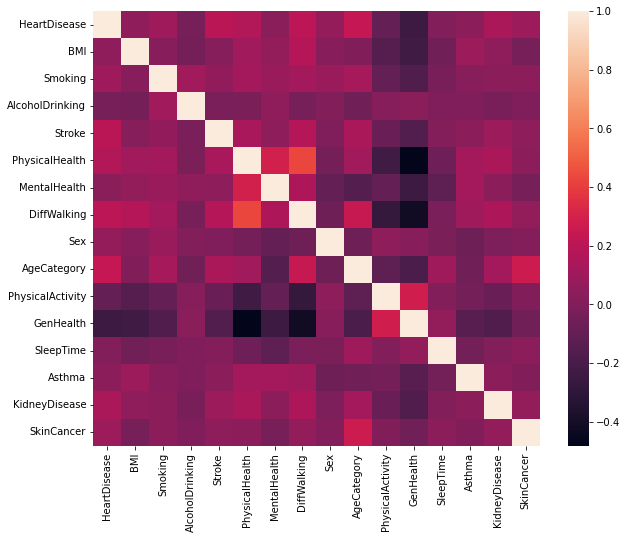

<IPython.core.display.Javascript object>

In [20]:
sns.heatmap(data.corr())
fig = plt.gcf()
fig.set_size_inches(10, 8)

In [21]:
data_plot = data.drop(binary_columns, axis=1)

<IPython.core.display.Javascript object>

In [22]:
sample_plot = data_plot[data_plot["HeartDisease"] == 1].copy()

<IPython.core.display.Javascript object>

In [23]:
sample_plot = pd.concat(
    [
        sample_plot,
        data_plot.loc[
            np.random.choice(
                data_plot[data_plot["HeartDisease"] != 1].index,
                len(sample_plot),
                replace=False,
            )
        ],
    ],
)

<IPython.core.display.Javascript object>

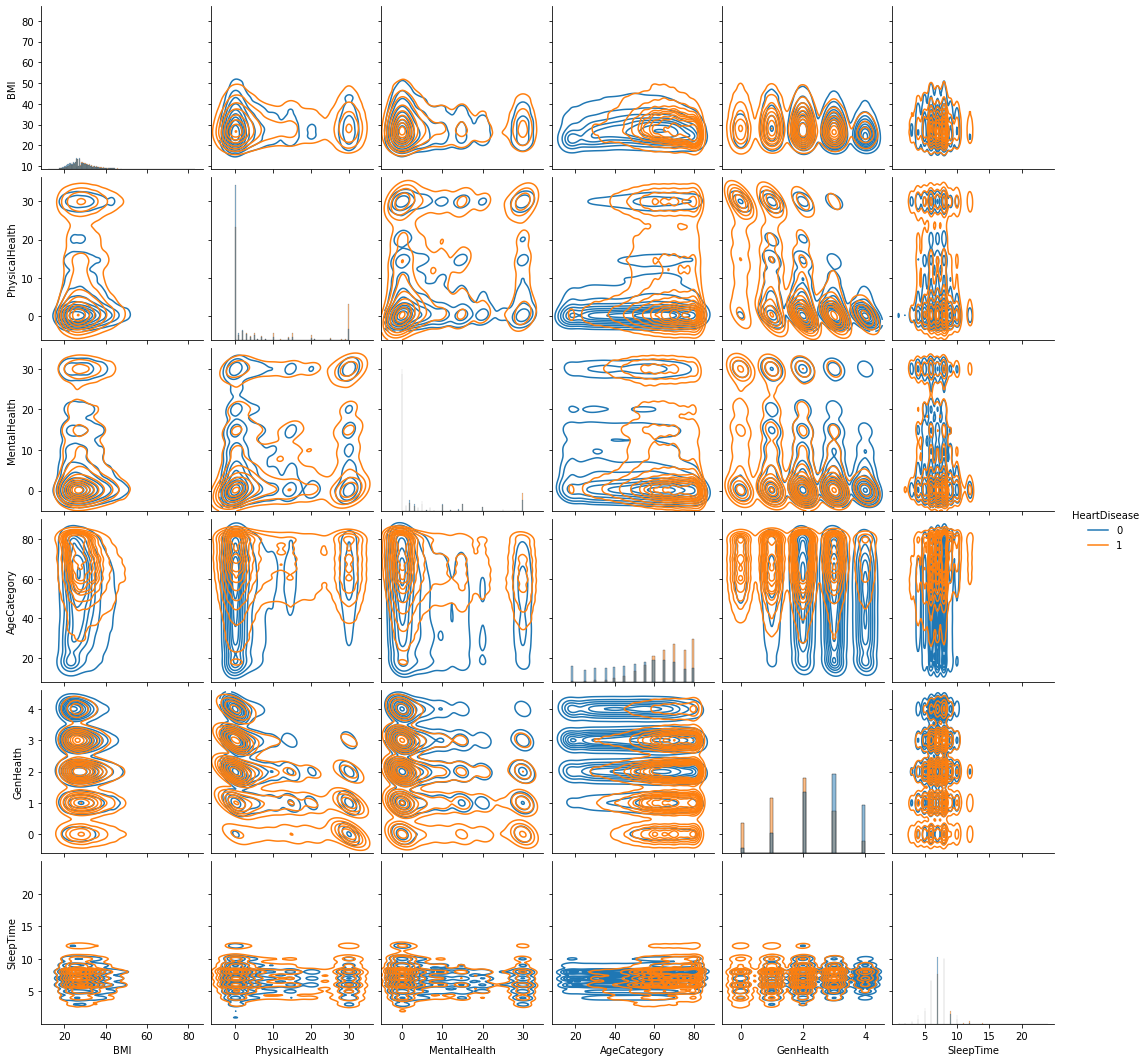

<IPython.core.display.Javascript object>

In [24]:
sns.pairplot(
    sample_plot,
    hue="HeartDisease",
    kind="kde",
    diag_kind="hist",
)

The plot above shows a very clear relation between the possibility of heart disease and other key indicators like age and general health and physical health, 

In [25]:
data[binary_columns + ["HeartDisease"]].groupby("HeartDisease").mean()

,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,PhysicalActivity,Asthma,KidneyDisease,SkinCancer
HeartDisease,,,,,,,,,
0,0.396246,0.070569,0.026263,0.117577,0.464572,0.788135,0.129741,0.028466,0.084942
1,0.585869,0.041683,0.160340,0.366346,0.589596,0.638914,0.180214,0.126219,0.181931


<IPython.core.display.Javascript object>

As seen in the table above smoking, previous stroke episodes, difficulty walking, physical activity, Asthma, kidney disease and skin cancer are all related with hearth disease, while alcohol drinking has little incidence.

There seems to be a relation between the incidence of heart disease and the sex of the person as the proportion of men in the dataset with heart disease is greater than the proportion of women. This relation has to be explored further as it may be explained when considering the effect of other variables.

# Modelling

Lets construct some machine learning models to see if we are able to predict hearth disease from the other variables.

In [26]:
data = pd.get_dummies(data, drop_first=True)

<IPython.core.display.Javascript object>

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("HeartDisease", axis=1), data["HeartDisease"], test_size=0.2
)

<IPython.core.display.Javascript object>

In [33]:
X_train_ss, X_test_ss, y_train_ss, y_test_ss = train_test_split(
    pd.DataFrame(
        columns=[x for x in data.columns if x != "HeartDisease"],
        data=StandardScaler().fit_transform(data.drop("HeartDisease", axis=1)),
    ),
    data["HeartDisease"],
    test_size=0.2,
)

<IPython.core.display.Javascript object>

First let's fit a logistic regression in order to have a baseline model

In [34]:
roc_scores = cross_val_score(
    LogisticRegression(),
    X_train_ss,
    y_train,
    cv=4,
    scoring=make_scorer(roc_auc_score),
)
acc_scores = cross_val_score(
    LogisticRegression(),
    X_train_ss,
    y_train,
    cv=4,
)

<IPython.core.display.Javascript object>

In [35]:
print(f"CV accuracy logistic regresion: {np.mean(acc_scores)}")
print(f"CV ROC AUC logistic regresion: {np.mean(roc_scores)}")

CV accuracy logistic regresion: 0.9145937241045045
CV ROC AUC logistic regresion: 0.5


<IPython.core.display.Javascript object>

Accuracy is high because the dataset is highly imbalanced, the ROC AUC score close to 0.5 shows that the model is almost as good as random choice. Fortunately other machine learning algorithms like Random Forest which will be implemented later are able to handle imbalanced data producing better results.

In [36]:
imbalance_factor = 1 / data["HeartDisease"].mean()

<IPython.core.display.Javascript object>

In [37]:
def gen_rf_hyperparameters():
    n_estimators = max(int(10 ** (np.random.random() * 1.5 + 1)),1)
    max_depth = np.random.choice([1, 2, 5, 10, 20])
    min_samples_leaf = np.random.randint(1, 100)
    class_weight = {0: 1, 1: (np.random.random() + 1) * imbalance_factor}
    max_features = np.random.random()
    return {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_leaf": min_samples_leaf,
        "class_weight": class_weight,
        "max_features": max_features,
    }

<IPython.core.display.Javascript object>

### Feature selection

In order to do feature selection the Boruta method will be used. This method trains multiple models on the dataset including permutations of columns and does an statistical test based on the feature importances of the attribute and its permutation in order to select which attributes have predictive power. Further information about Boruta can be found in the <a href=https://danielhomola.com/boruta_py>documentation</a>.

In [38]:
bor_iter = 8
columns_to_retain = set()
for i in range(bor_iter):
    print(
        f"Iteration {i} - {bor_iter}: Boruta - {datetime.datetime.today().strftime('%H:%M:%S')}"
    )
    params = gen_rf_hyperparameters()
    model = RandomForestClassifier(**params)
    boruta = BorutaPy(estimator=model, n_estimators="auto", max_iter=100)
    boruta.fit(
        np.array(X_train),
        np.array(y_train),
    )
    columns_to_retain = columns_to_retain.union(
        X_train.columns[boruta.support_].to_list()
    )
    if len(columns_to_retain) == len(X_train.columns):
        print(f'All columns were found important')
        break
print(f'Columns to retain: {columns_to_retain}')

Iteration 0 - 3: Boruta - 17:36:08
Iteration 1 - 3: Boruta - 17:41:09
Iteration 2 - 3: Boruta - 17:44:00
Columns to retain: {'Smoking', 'PhysicalActivity', 'KidneyDisease', 'Stroke', 'Asthma', 'Race_Hispanic', 'Sex', 'AgeCategory', 'SleepTime', 'Diabetic_Yes', 'Race_White', 'DiffWalking', 'PhysicalHealth', 'SkinCancer', 'MentalHealth', 'BMI', 'GenHealth'}


<IPython.core.display.Javascript object>

### Cross validation

Now the hyperparameters for the model are going to be selected through 100 iterations of cross-validation.

In [39]:
n_cv = 100

<IPython.core.display.Javascript object>

In [40]:
score = 0.5
final_params = None

<IPython.core.display.Javascript object>

In [41]:
for i in range(n_cv):
    if i % 5 == 0:
        print(
            f"Iteration {i} - {n_cv}: CV - {datetime.datetime.today().strftime('%H:%M:%S')}"
        )
    params = gen_rf_hyperparameters()
    model = RandomForestClassifier(**params)
    cv_score = np.mean(
        cross_val_score(
            model,
            X_train,
            y_train,
            cv=4,
            scoring=make_scorer(roc_auc_score),
        )
    )
    if cv_score > score:
        score = cv_score
        final_params = params
        print(f"Iter {i} - ROC AUC score :{score}")

Iteration 0 - 10: CV - 18:07:29
Iter 0 - ROC AUC score :0.6586694128986477
Iter 1 - ROC AUC score :0.7521617532638329
Iter 2 - ROC AUC score :0.7587408879284427
Iter 3 - ROC AUC score :0.7630889094368438
Iteration 5 - 10: CV - 18:09:08


<IPython.core.display.Javascript object>

### Model exploration

The model is now fitted with the best set of hyperparameters and evaluated on the test set

In [42]:
model = RandomForestClassifier(**final_params)

<IPython.core.display.Javascript object>

In [43]:
model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 12.819122503388591}, max_depth=10,
                       max_features=0.47576147097901833, min_samples_leaf=96,
                       n_estimators=18)

<IPython.core.display.Javascript object>

In [44]:
y_test_pred_proba = model.predict_proba(X_test)

<IPython.core.display.Javascript object>

In [45]:
y_train_pred_proba = model.predict_proba(X_train)

<IPython.core.display.Javascript object>

#### Metrics

Lets plot the resulting train and test ROC curves in order to evaluate the performance of the model

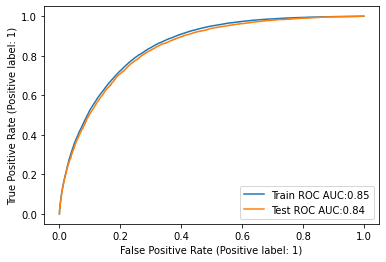

<IPython.core.display.Javascript object>

In [47]:
fig, ax = plt.subplots()
plot_roc_curve(
    model,
    X_train,
    y_train,
    ax=ax,
    label=f"Train ROC AUC:{round(roc_auc_score(y_train, y_train_pred_proba[:, 1]),2)}",
)
plot_roc_curve(
    model,
    X_test,
    y_test,
    ax=ax,
    label=f"Test ROC AUC:{round(roc_auc_score(y_test, y_test_pred_proba[:, 1]),2)}",
)

The random forest model achieves considerable predictive power unlike the logistic regresion previously fitted. The confusion matrix shown below is evidence of the utility of the model as it can identify high risk individuals so that preventive meassures can be taken.

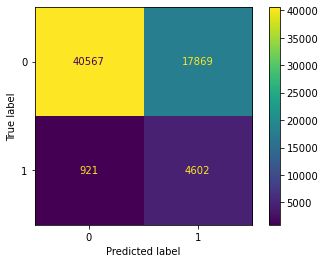

<IPython.core.display.Javascript object>

In [48]:
plot_confusion_matrix(model, X_test, y_test)

#### SHAP

Now lets use Shapely Additive values to explore feature importance and contribution. This methodology allos to estimate the marginal contribution of each feature for every prediction. More information about the topic is available <a href=https://christophm.github.io/interpretable-ml-book/shapley.html>here</a>.

In [74]:
explainer = shap.TreeExplainer(model)

<IPython.core.display.Javascript object>

In [75]:
shap_values = explainer.shap_values(X_test, y_test)

<IPython.core.display.Javascript object>

The following plot shows the shapely values, or marginal contribution towards the prediction for every record of test set. One point in the following graph in the AgeCategory column represents a single observation whose AgeCategory value is encoded in the color, and has the marginal contribution calculated plotted in the x-axis. An easier way to interpret the graph is by understanding the width of the point cloud as the feature importance and by knowing that if red points are on the right of the plot, then there is a positive correlation between the feature and heart disease, and viceversa.

This plot shows that the most important factors contributing to the risk of heart disease are age and general well beign, followed by sex, diabetes, dificulty walking, previous stroke episodes and smoking.

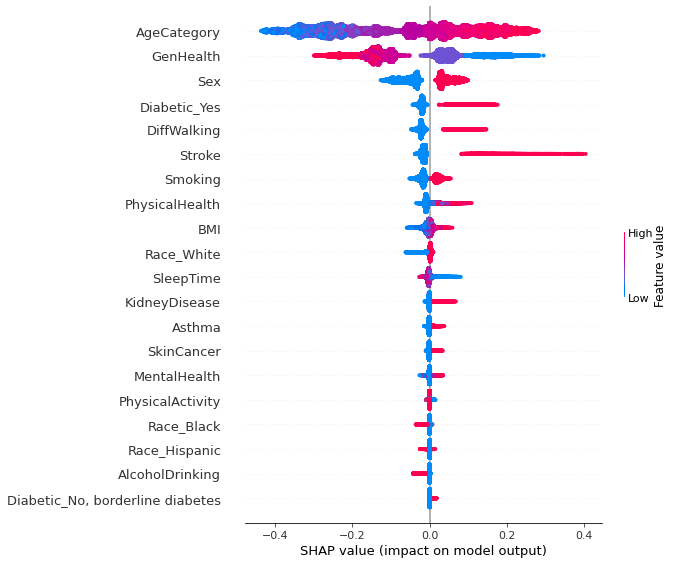

<IPython.core.display.Javascript object>

In [72]:
shap.summary_plot(shap_values[1], X_test)